# Classification of patent documents

This code classifies patent documents according to their language. The provided patent documents belong to one of the following three technology fields: vehicle brakes (patent class F16D65/00), density determination (patent class G01N9/00) and insulin pumps (patent class A61M5/142).

## 1. Load necessary libraries

In [0]:
# if using google colab
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import sys

import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipyd
import tensorflow as tf
import collections
import time
import codecs

# crc, 12.3.2020, import additional modules for input preparation
import pandas as pd
import os
import shutil
import PIL
import PIL.Image
import PIL.ImageFont
import PIL.ImageOps
import PIL.ImageDraw
###########################################

from tensorflow import keras #frm

# We'll tell matplotlib to inline any drawn figures like so:
%matplotlib inline
plt.style.use('ggplot')

from IPython.core.display import HTML
HTML("""<style> .rendered_html code { 
    padding: 2px 5px;
    color: #0000aa;
    background-color: #cccccc;
} </style>""")

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## 2. Prepare input text files
The input text files are generated from the Excel files which contain the text data for training and validation.

In [0]:
# crc, 12.3.2020
# We upload the Excel files from the local machine interactively.

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [0]:
#crc, 12.3.2020
# We read in the text data into pandas data frames.

dataframe_A61M5_142 = pd.read_excel('claims_Patente_Insulinpumpen_A61M5_142.xlsx',header=None)
dataframe_G01N9_00 = pd.read_excel('claims_Patente_Dichtebestimmung_G01N9_00.xlsx',header=None)
dataframe_F16D65_00 = pd.read_excel('claims_Patente_Bremsen_F16D65_00.xlsx',header=None)

In [0]:
# crc, 12.3.2020
# We convert the pandas data frames into numpy arrays for easier manipulation.

data_A61M5_142 = np.array(dataframe_A61M5_142)
data_G01N9_00 = np.array(dataframe_G01N9_00)
data_F16D65_00 = np.array(dataframe_F16D65_00)

In [0]:
# crc, 12.3.2020
# We join all text data in order to build raw dictionary data.

data_dictionary = np.concatenate((data_A61M5_142,data_G01N9_00,data_F16D65_00))   

In [0]:
# crc, 12.3.2020
# We clean all previously generated text files and their folders

current_directory = os.getcwd()
with os.scandir(current_directory) as it:
    for entry in it:
        if entry.name == 'A61M5_142_txt':
            shutil.rmtree(entry.name)
        if entry.name == 'G01N9_00_txt':
            shutil.rmtree(entry.name)
        if entry.name == 'F16D65_00_txt':
            shutil.rmtree(entry.name)
        if entry.name == 'A61M5_142_dump_txt':
            shutil.rmtree(entry.name)
        if entry.name == 'G01N9_00_dump_txt':
            shutil.rmtree(entry.name)
        if entry.name == 'F16D65_00_dump_txt':
            shutil.rmtree(entry.name)

In [0]:
# crc, 12.3.2020
# We create folders for text files

os.mkdir('A61M5_142_txt')
os.mkdir('G01N9_00_txt')
os.mkdir('F16D65_00_txt')

In [0]:
# crc, 12.3.2020
# We create a text file for every text cell in the Excel files

for i in range(len(data_A61M5_142)):
    np.savetxt('A61M5_142_txt/claims_A61M5_142_{0:d}.txt'.format(i),data_A61M5_142[i],fmt='%s',newline='')
    path_txt = 'A61M5_142_txt/claims_A61M5_142_{0:d}.txt'.format(i)
for i in range(len(data_G01N9_00)):
    np.savetxt('G01N9_00_txt/claims_G01N9_00_{0:d}.txt'.format(i),data_G01N9_00[i],fmt='%s',newline='')
    path_txt = 'G01N9_00_txt/claims_G01N9_00_{0:d}.txt'.format(i)
for i in range(len(data_F16D65_00)):
    np.savetxt('F16D65_00_txt/claims_F16D65_00_{0:d}.txt'.format(i),data_F16D65_00[i],fmt='%s',newline='')
    path_txt = 'F16D65_00_txt/claims_F16D65_00_{0:d}.txt'.format(i)

In [0]:
# crc, 12.3.2020
# We clean the directory for the dictionary text data.

current_directory = os.getcwd()
with os.scandir(current_directory) as it:
    for entry in it:
        if entry.name == 'dictionary_txt':
            shutil.rmtree(entry.name)

In [0]:
# crc, 12.3.2020
# We create the directory for the dictionary text data.

os.mkdir('dictionary_txt')

In [0]:
# crc, 12.3.2020
# We dump all claims in one text file to create the dictionary text data.

np.savetxt('dictionary_txt/dictionary.txt',data_dictionary,fmt='%s',newline=' ')

## 3. Load the text data

In [0]:
#This function from Tutorial VI reads input text data, splits them into words and saves the words in to a Numpy array.

def read_data(fname):
    with codecs.open(fname, 'r', encoding='utf-8',
                 errors='ignore') as f:
        content = f.readlines()
    content = [x.strip() for x in content]
    content = [word for i in range(len(content)) for word in content[i].split()]
    content = np.array(content)
    return content

In [0]:
text_label = ['F16D65_00', 'G01N9_00', 'A61M5_142']

In [0]:
# We read text data for use in dictionary creation.
# Text for all technology fields including stop words.

text_dictionary_sw = read_data('dictionary_txt/dictionary.txt')

## 4. Build dataset
We will assign an id to each word, and make dictionaries word->id and id->word.
The most frequently repeating words have lowest id

In [0]:
# This function builds the dictionary including stop words.

def build_dataset(words):
    count = collections.Counter(words).most_common()
    dictionary = {}
    for word, _ in count:
        dictionary[word] = len(dictionary)

    ############################################frm
    dictionary = {k:(v+2) for k, v in dictionary.items()}
    dictionary["<unk>"] = 1 #Padding = Füllstoff :-)
    dictionary["<pad>"] = 0 #Brauchen wir vielleicht nicht
    ############################################frm


    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return dictionary, reverse_dictionary, count
   

In [0]:
# We generate the  dictionary for all technology fields.

dictionary = {}

dictionary_sw, reverse_dictionary_sw, count = build_dataset(text_dictionary_sw)
vocab_size = len(dictionary_sw)


In [0]:
# Added for debugging.

print(dictionary_sw)
print(reverse_dictionary_sw)

{'the': 2, 'of': 3, 'a': 4, 'to': 5, 'and': 6, 'said': 7, 'The': 8, 'is': 9, 'in': 10, 'claim': 11, 'wherein': 12, 'first': 13, 'for': 14, 'an': 15, 'second': 16, 'at': 17, ':': 18, 'with': 19, 'brake': 20, 'from': 21, 'one': 22, 'or': 23, 'fluid': 24, 'least': 25, 'that': 26, 'by': 27, 'on': 28, 'device': 29, 'method': 30, 'portion': 31, 'as': 32, 'system': 33, 'A': 34, 'according': 35, 'comprises': 36, 'between': 37, '1,': 38, 'end': 39, 'further': 40, 'which': 41, 'surface': 42, 'having': 43, 'means': 44, 'sensor': 45, 'assembly': 46, 'are': 47, 'comprising': 48, 'pump': 49, 'apparatus': 50, 'configured': 51, 'flow': 52, 'housing': 53, 'has': 54, 'pressure': 55, 'density': 56, 'into': 57, 'comprising:': 58, 'control': 59, 'unit': 60, 'when': 61, 'through': 62, 'being': 63, 'each': 64, 'plurality': 65, 'be': 66, 'includes': 67, 'chamber': 68, 'within': 69, 'member': 70, 'body': 71, 'measuring': 72, 'disc': 73, 'infusion': 74, 'tube': 75, 'more': 76, 'liquid': 77, 'position': 78, 'mat

In [0]:
# We remove stop words from the dictionary and a reverse dictionary.
# The reverse dictionary is useful for debugging.

stop_words = {'a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be',
 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do',
 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has',
 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
 'into', 'is', 'isn', "isn't", 'it', "it's", 'its', 'itself', 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't",
 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves',
 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she', "she's", 'should', "should've", 'shouldn', "shouldn't", 'so', 'some', 'such',
 't', 'than', 'that', "that'll", 'the', 'their', 'theirs', 'them', 'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 'through', 'to',
 'too', 'under', 'until', 'up', 've', 'very', 'was', 'wasn', "wasn't", 'we', 'were', 'weren', "weren't", 'what', 'when', 'where', 'which', 'while',
 'who', 'whom', 'why', 'will', 'with', 'won', "won't", 'wouldn', "wouldn't", 'y', 'you', "you'd", "you'll", "you're", "you've", 'your', 'yours',
 'yourself', 'yourselves'}

dictionary = {}

for i in dictionary_sw:
    if i.lower() not in stop_words:
        dictionary[i.lower()] = dictionary_sw[i]  # all words are in low characters.
x = len(dictionary)

reverse_dictionary = dict(zip(dictionary.values(),dictionary.keys()))  


In [0]:
# Added for debugging.

print(dictionary)
print(reverse_dictionary)

{'said': 7, 'claim': 474, 'wherein': 12, 'first': 1833, 'second': 1914, ':': 18, 'brake': 479, 'one': 2706, 'fluid': 1127, 'least': 25, 'device': 11021, 'method': 13882, 'portion': 8251, 'system': 13931, 'according': 4441, 'comprises': 13051, '1,': 38, 'end': 4484, 'surface': 5794, 'means': 44, 'sensor': 1634, 'assembly': 3264, 'comprising': 48, 'pump': 13898, 'apparatus': 9632, 'configured': 51, 'flow': 4565, 'housing': 1660, 'pressure': 2736, 'density': 2150, 'comprising:': 58, 'control': 2710, 'unit': 60, 'plurality': 65, 'includes': 67, 'chamber': 4174, 'within': 5717, 'member': 70, 'body': 4165, 'measuring': 4064, 'disc': 1963, 'infusion': 13919, 'tube': 5542, 'liquid': 13918, 'position': 17756, 'material': 2635, 'delivery': 2970, 'reservoir': 3093, 'disposed': 82, '1': 83, 'element': 84, 'inner': 3410, 'drive': 2216, 'and/or': 87, 'side': 11072, 'connected': 89, 'including': 90, 'valve': 4249, 'temperature': 3981, 'value': 96, 'signal': 6570, 'direction': 14917, 'outer': 2426, 'c

In [0]:
# We read the text files and label them.

sample_number = 100      # the number of text files to use
fw = 250 #frm: Anzahl der Wörter in einerm Dokument

labels_F16D65_00 = []
texts_F16D65_00 = []
labels_G01N9_00 = []
texts_G01N9_00 = []
labels_A61M5_142 = []
texts_A61M5_142 = []

#F16D65_00
for sample in range(sample_number):
  text_sw = read_data('F16D65_00_txt/claims_F16D65_00_%d.txt'%sample)   # stop words are also read in
  text =[]      # initializes this variable each time before removing stop words from texts 
  for word in text_sw:
    if word.lower() not in stop_words:      # removes stop words from text
      text.append(word.lower())
  texts_F16D65_00.append(text)
  labels_F16D65_00.append([1,0,0])

#G01N9_00
for sample in range(sample_number):
  text_sw = read_data('G01N9_00_txt/claims_G01N9_00_%d.txt'%sample)
  text =[]      # initializes this variable each time before removing stop words from texts 
  for word in text_sw:
    if word.lower() not in stop_words:      # removes stop words from text
      text.append(word.lower())
  texts_G01N9_00.append(text)
  labels_G01N9_00.append([0,1,0])   

#A61M5_142
for sample in range(sample_number):
  text_sw = read_data('A61M5_142_txt/claims_A61M5_142_%d.txt'%sample)
  text =[]      # initializes this variable each time before removing stop words from texts 
  for word in text_sw:
    if word.lower() not in stop_words:      # removes stop words from text
      text.append(word.lower())
  texts_A61M5_142.append(text)
  labels_A61M5_142.append([0,0,1])

Then the whole text will look as a sequence of word ids:

In [0]:
# We convert the texts to numerical vector representation and save them in lists.
# Using the if statement we ignore words in the text which are not in the dictionary and avoid execution errors.

#F16D65_00
words_as_int_F16D65_00 = []
words_as_int = []
for sample in range(sample_number):
  words_as_int = [dictionary[w] for w in texts_F16D65_00[sample] if w in dictionary]
  words_as_int_F16D65_00.append(words_as_int)

#G01N9_00

words_as_int_G01N9_00 = []
words_as_int = []
for sample in range(sample_number):
  words_as_int = [dictionary[w] for w in texts_G01N9_00[sample] if w in dictionary]
  words_as_int_G01N9_00.append(words_as_int)

#A61M5_142

words_as_int_A61M5_142 = []
words_as_int = []
for sample in range(sample_number):
  words_as_int = [dictionary[w] for w in texts_A61M5_142[sample] if w in dictionary]
  words_as_int_A61M5_142.append(words_as_int)

In [0]:
# We trim the word sequences to 200 words.


#F16D65_00
words_as_int_F16D65_00 = keras.preprocessing.sequence.pad_sequences(words_as_int_F16D65_00, value=dictionary["<pad>"], padding="post", truncating="post", maxlen=fw)
#G01N9_00
words_as_int_G01N9_00 = keras.preprocessing.sequence.pad_sequences(words_as_int_G01N9_00, value=dictionary["<pad>"], padding="post", truncating="post", maxlen=fw)
#A61M5_142
words_as_int_A61M5_142 = keras.preprocessing.sequence.pad_sequences(words_as_int_A61M5_142, value=dictionary["<pad>"], padding="post", truncating="post", maxlen=fw)

In [0]:
# Added for debugging purposes: we test conversion of words into integers for individual text files.

words_as_int = []
words_as_int = [dictionary[w] for w in texts_F16D65_00[0] if w in dictionary]
words_as_int = keras.preprocessing.sequence.pad_sequences([words_as_int], value=dictionary["<pad>"], padding="post", truncating="post", maxlen=fw)

print(texts_F16D65_00[0][0:10])
for i in range(10):
  print(reverse_dictionary[words_as_int[0][i]])

['1.', 'vehicle-mounted', 'apparatus,', 'comprising:', 'motor', 'unit', 'comprising', 'drive', 'motor', 'speed']
1.
vehicle-mounted
apparatus,
comprising:
motor
unit
comprising
drive
motor
speed


In [0]:
words_as_int_A61M5_142[0]

array([  153, 13896, 13898,  2216,  7051,  7238,  4469, 13896, 13881,
          90,  4221,  3462,  2216,  7051,    58,  2216,  1660,    90,
       11682,  1968,    82,   166,    25,  1168,  1833, 17756,  1047,
        1914, 17756,   179,     7,  1374,  1968, 14199,  3678,   166,
        4221, 11593,  5717, 13896, 11683,    65,  8622,   669,    82,
        1235, 14894, 14199,   310,  3463,  1833, 17756,  8620,  1914,
       17756,  1554,   420, 11684, 11685,  1455,   930,  7243,  1833,
       17756,  1283,  1914,   614,  1455,    82,  1398,  8622,   669,
        3463,  1833, 17756,  1455,  7243,  1833,   614,   420,  8622,
         669,  1833,  3463, 17756,  1455,   893,  1283,  1914, 11686,
        8622,   669,    82,   634,   166,  1968,  1168,  1833, 17756,
        1047,  1914, 17756,  8622,   669,   310,  3463,  1833, 17756,
        8620,  1914,   548,   162, 13896, 13898,  2216,  7051,   474,
          38,    12,    65,  8622,   669,    67,    25,  2706,  4470,
        5808,  8973,

In [0]:
# We convert the list of lists containing the word ids into stacked arrays. This is needed for using data for model training and validation.

words_as_int_F16D65_00_array = words_as_int_F16D65_00[0]     #array initialization
words_as_int_G01N9_00_array = words_as_int_G01N9_00[0]
words_as_int_A61M5_142_array = words_as_int_A61M5_142[0]

for sample in range(1,sample_number):
  words_as_int_F16D65_00_array = np.vstack((words_as_int_F16D65_00_array,words_as_int_F16D65_00[sample]))
  words_as_int_G01N9_00_array = np.vstack((words_as_int_G01N9_00_array,words_as_int_G01N9_00[sample]))
  words_as_int_A61M5_142_array = np.vstack((words_as_int_A61M5_142_array,words_as_int_A61M5_142[sample]))

## 5. Build model

We will build the model in TF2.
It contains one embedding layer, one pooling layer, three hidden dense layers and one dense output layer. The output layer includes three units corresponding to the technology fields.

In [0]:
# We define and compile the model.

model = keras.Sequential()
model.add(keras.layers.Embedding(2*x,16)) 
model.add(keras.layers.GlobalAveragePooling1D()) #vereinfacht/reduziert den Input aus dem Embedding-Layer

model.add(keras.layers.Dense(32,  activation = "relu"))
model.add(keras.layers.Dense(16,  activation = "relu"))
#model.add(keras.layers.Dense(32,  activation = "relu")) 
#model.add(keras.layers.Dense(16,  activation = "sigmoid"))
model.add(keras.layers.Dense(3,  activation = "softmax", name='classification_layer')) 

model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

W0 = model.get_weights()  # saves the model weights
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          564576    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                544       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
classification_layer (Dense) (None, 3)                 51        
Total params: 565,699
Trainable params: 565,699
Non-trainable params: 0
_________________________________________________________________


## Train

We build the training and validation data sets at a ratio of 9:1 and train the model.

In [0]:
ratio = 0.9   #ratio of training to validation data
n_train = int(sample_number*ratio)

# We generate the training and validation text sets

text_train = np.concatenate((words_as_int_F16D65_00_array[:n_train],words_as_int_G01N9_00_array[:n_train],words_as_int_A61M5_142_array[:n_train]))
text_validation = np.concatenate((words_as_int_F16D65_00_array[n_train:,:],words_as_int_G01N9_00_array[n_train:,:],words_as_int_A61M5_142_array[n_train:,:]))

# We convert the label lists into arrays

labels_F16D65_00 = np.array(labels_F16D65_00)
labels_G01N9_00 = np.array(labels_G01N9_00)
labels_A61M5_142 = np.array(labels_A61M5_142)

labels_train = np.concatenate((labels_F16D65_00[:n_train],labels_G01N9_00[:n_train],labels_A61M5_142[:n_train]))
labels_validation = np.concatenate((labels_F16D65_00[n_train:],labels_G01N9_00[n_train:],labels_A61M5_142[n_train:]))

model.set_weights(W0)
training_history = model.fit(text_train,labels_train,batch_size=10,epochs=60,validation_data=(text_validation,labels_validation))

Train on 270 samples, validate on 30 samples
Epoch 1/60
270/270 [==============================] - 2s 9ms/sample - loss: 1.0973 - accuracy: 0.4185 - val_loss: 1.0933 - val_accuracy: 0.6000
Epoch 2/60
270/270 [==============================] - 0s 925us/sample - loss: 1.0851 - accuracy: 0.5333 - val_loss: 1.0780 - val_accuracy: 0.5667
Epoch 3/60
270/270 [==============================] - 0s 852us/sample - loss: 1.0463 - accuracy: 0.6630 - val_loss: 1.0358 - val_accuracy: 0.5667
Epoch 4/60
270/270 [==============================] - 0s 950us/sample - loss: 0.9556 - accuracy: 0.6667 - val_loss: 0.9482 - val_accuracy: 0.5667
Epoch 5/60
270/270 [==============================] - 0s 982us/sample - loss: 0.7946 - accuracy: 0.6667 - val_loss: 0.8369 - val_accuracy: 0.5667
Epoch 6/60
270/270 [==============================] - 0s 849us/sample - loss: 0.6191 - accuracy: 0.6667 - val_loss: 0.7350 - val_accuracy: 0.5667
Epoch 7/60
270/270 [==============================] - 0s 945us/sample - loss: 0.4

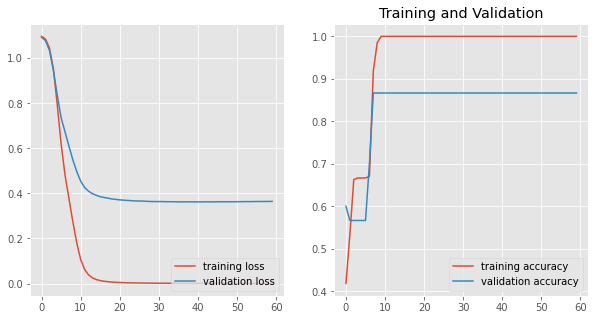

In [0]:
# We plot the training history

fig, axs = plt.subplots(1, 2, figsize=(10,5))
plt.title('Training and Validation')
axs[0].plot(training_history.epoch, training_history.history['loss'])
axs[0].plot(training_history.epoch, training_history.history['val_loss'])
axs[0].legend(('training loss', 'validation loss'), loc='lower right')
axs[1].plot(training_history.epoch, training_history.history['accuracy'])
axs[1].plot(training_history.epoch, training_history.history['val_accuracy'])

axs[1].legend(('training accuracy', 'validation accuracy'), loc='lower right')
plt.savefig("Training_and_Validation.png")
plt.show()

In [0]:
# This function converts an arbitrary text into word ids.
def patent_encode(s):
  encoded = []

  for word in s:
    if word.lower() in dictionary:
      encoded.append(dictionary[word.lower()])

  return encoded

In [0]:
# This is the inference part. We predict the technology field for inputs which were not used either for training or validation.
# We use the read_data function to read in text and split the text into words. 

contents_sw = read_data("A61M5_142_txt/claims_A61M5_142_124.txt")   # reads stop words, too.

contents = []      # initializes this variable each time before removing stop words from texts 
for word in contents_sw:
  if word.lower() not in stop_words:      # removes stop words from text
    contents.append(word.lower())


encode = []     #initializes the variables for saving the encoding

encode = patent_encode(contents)    # converts text to word ids.
encode = keras.preprocessing.sequence.pad_sequences([encode], value=dictionary["<pad>"], padding="post", truncating="post", maxlen=fw)

# Added for debugging purposes.
# We print the first 10 words of the input text, the corresponding encoding and the reverse translation.

print(contents[0:9])

for i in range(9):
 print(encode[0][i])
 print(reverse_dictionary[encode[0][i]])

 ###############################################

predict = model.predict(encode)       # predicts technology field

print(predict[0]) 

# prediction output

if predict[0][0]>0.5:       
  print("Es handelt sich um ein Patent im Bereich Fahrzeugbremsen")
elif predict[0][1]>0.5:
  print("Es handelt sich um ein Patent im Bereich Dichtebestimmung")
elif predict[0][2]>0.5:
  print("Es handelt sich um ein Patent im Bereich Insulinpumpen")
else:
  print("Keine Kategorie erkannt")

['1.', 'container,', 'combination', 'nf', 'open', 'ended', 'outer', 'receptacle,', 'inner']
153
1.
617
container,
7687
combination
9570
nf
17806
open
9712
ended
2426
outer
2512
receptacle,
3410
inner
[0.9595376  0.03499214 0.00547029]
Es handelt sich um ein Patent im Bereich Fahrzeugbremsen


In [0]:
#Test frm
# This is the inference part. We predict the technology field for inputs which were not used either for training or validation.
# We use the read_data function to read in text and split the text into words. 

for i in range(100,len(data_G01N9_00),1):
  
  contents_sw = read_data("G01N9_00_txt/claims_G01N9_00_{0:d}.txt".format(i))   # reads stop words, too.

  contents = []      # initializes this variable each time before removing stop words from texts 
  for word in contents_sw:
    if word.lower() not in stop_words:      # removes stop words from text
     contents.append(word.lower())


  encode = []     #initializes the variables for saving the encoding

  encode = patent_encode(contents)    # converts text to word ids.
  encode = keras.preprocessing.sequence.pad_sequences([encode], value=dictionary["<pad>"], padding="post", truncating="post", maxlen=fw)

# Added for debugging purposes.
# We print the first 10 words of the input text, the corresponding encoding and the reverse translation.


 ###############################################

  predict = model.predict(encode)       # predicts technology field

  print(predict[0]) 

# prediction output

  if predict[0][0]>0.5:       
   print("Es handelt sich um ein Patent im Bereich Fahrzeugbremsen")
  elif predict[0][1]>0.5:
    print("Es handelt sich um ein Patent im Bereich Dichtebestimmung")
  elif predict[0][2]>0.5:
    print("Es handelt sich um ein Patent im Bereich Insulinpumpen")
  else:
    print("Keine Kategorie erkannt")

[0.01708854 0.72441995 0.2584915 ]
Es handelt sich um ein Patent im Bereich Dichtebestimmung
[0.74655163 0.21922302 0.03422534]
Es handelt sich um ein Patent im Bereich Fahrzeugbremsen
[0.03387364 0.9076304  0.05849595]
Es handelt sich um ein Patent im Bereich Dichtebestimmung
[0.58646065 0.31933418 0.09420519]
Es handelt sich um ein Patent im Bereich Fahrzeugbremsen
[4.886720e-04 9.990460e-01 4.653101e-04]
Es handelt sich um ein Patent im Bereich Dichtebestimmung
[1.4471827e-03 9.9756253e-01 9.9028414e-04]
Es handelt sich um ein Patent im Bereich Dichtebestimmung
[0.00321091 0.95359963 0.04318944]
Es handelt sich um ein Patent im Bereich Dichtebestimmung
[0.00245081 0.99612963 0.00141957]
Es handelt sich um ein Patent im Bereich Dichtebestimmung
[1.5668919e-04 9.9962461e-01 2.1870254e-04]
Es handelt sich um ein Patent im Bereich Dichtebestimmung
[1.7433029e-04 9.9975139e-01 7.4288968e-05]
Es handelt sich um ein Patent im Bereich Dichtebestimmung
[4.2343381e-04 9.9911851e-01 4.5802363e

In [0]:
#frm Diese Zelle funktioniert nicht

#for i in range(100, 120,1):
#  with open("F16D65_00_txt/claims_F16D65_00_{0:d}.txt".format(i)) as f:
#    encode = []
#    for line in f.readlines():
#     # nline = line.replace(",","").replace(".","").replace("(,)","").replace(")","").replace(":","").strip().split()
#      nline = line.strip().split()
#      encode = patent_encode(nline)
#      encode = keras.preprocessing.sequence.pad_sequences([encode], value=dictionary["<pad>"], padding="post", maxlen=fw)
## Hier könnte man gleich einbauen, dass das Dokument, hier die "Testdatei.txt" direkt vom gelernten Modell klassiert wird
#  predict = model.predict(encode)
#  #print(line)
#  #print(encode)
#  print(predict[0]) 
#  print(i)
#  if predict[0][0]>0.5:
#    print("Es handelt sich um ein Patent im Bereich Fahrzeugbremsen")
#  elif predict[0][1]>0.5:
#    print("Es handelt sich um ein Patent im Bereich Dichtebestimmung")
#  elif predict[0][2]>0.5:
#    print("Es handelt sich um ein Patent im Bereich Insulinpumpen")
#  else:
#    print("Keine Kategorie erkannt")

In [0]:
# We save the model for inference.

!rm -r inference_model      # we delete any older model versions.
tf.saved_model.save(model, "inference_model")   # we save the current model version.

rm: cannot remove 'inference_model': No such file or directory
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: inference_model/assets


We create a wrapper for inference using the saved model as in Tutorial V.

In [0]:
class Inferer:
  def __init__(self, model_path, output_name):
    self.mod = tf.saved_model.load(model_path)
    self.func = self.mod.signatures["serving_default"]
    self.output_name = output_name
    self.class_names = np.array(['F16D65_00', 'G01N9_00', 'A61M5_142'])
    self.max_len = 64

  def infere_class_batch(self, inputs):
    probabilities = self.func(tf.constant(inputs))[self.output_name].numpy()
    classes = np.argmax(probabilities, axis=1)
    probs = probabilities[np.arange(len(classes)), classes]
    return classes, probs

  def infere_class(self, inputs):
    n = len(inputs)
    if n > self.max_len:
      classes = []
      probs = []
      for i in range( (n+self.max_len-1) // self.max_len):
        batch = inputs[i* self.max_len : (i+1)* self.max_len]
        batch_classes, batch_probs = self.infere_class_batch(batch)
        classes.append(batch_classes)
        probs.append(batch_probs)
      classes = np.concatenate(classes)
      probs = np.concatenate(probs)
    else:
      classes, probs = self.infere_class_batch(inputs)

    return classes, probs

  def infere(self, inputs, prob=False):
    classes, probs = self.infere_class(inputs)
    cn = self.class_names[classes]
    return (cn, probs) if prob else cn

In [0]:
# We create an instance of the class Inferer

inf = Inferer('inference_model', model.output_names[0])

In [0]:
# We clean all previously generated inference text files and their folders

current_directory = os.getcwd()
with os.scandir(current_directory) as it:
    for entry in it:
        if entry.name == 'inference_txt':
            shutil.rmtree(entry.name)

In [0]:
# We create the directory for the inference text data.

os.mkdir('inference_txt')

In [0]:
# We create a dataset for inference. We choose the vehicle brakes technology field.

# We read the text files and label them.

labels_F16D65_00_inf = []
texts_F16D65_00_inf = []

#F16D65_00
for sample in range(sample_number,len(data_F16D65_00)):
  text_sw = read_data('F16D65_00_txt/claims_F16D65_00_%d.txt'%sample)   # stop words are also read in
  text =[]      # initializes this variable each time before removing stop words from texts 
  for word in text_sw:
    if word.lower() not in stop_words:      # removes stop words from text
      text.append(word.lower())
  texts_F16D65_00_inf.append(text)
  labels_F16D65_00_inf.append([1,0,0])

#frm
labels_A61M5_142_inf = []
texts_A61M5_142_inf = []

#A61M5_142
for sample in range(sample_number,len(data_A61M5_142)):
  text_sw = read_data('A61M5_142_txt/claims_A61M5_142_%d.txt'%sample)   # stop words are also read in
  text =[]      # initializes this variable each time before removing stop words from texts 
  for word in text_sw:
    if word.lower() not in stop_words:      # removes stop words from text
      text.append(word.lower())
  texts_A61M5_142_inf.append(text)
  labels_A61M5_142_inf.append([1,0,0])

  #frm
labels_G01N9_00_inf = []
texts_G01N9_00_inf = []

#G01N9_00
for sample in range(sample_number,len(data_G01N9_00)):
  text_sw = read_data('G01N9_00_txt/claims_G01N9_00_%d.txt'%sample)   # stop words are also read in
  text =[]      # initializes this variable each time before removing stop words from texts 
  for word in text_sw:
    if word.lower() not in stop_words:      # removes stop words from text
      text.append(word.lower())
  texts_G01N9_00_inf.append(text)
  labels_G01N9_00_inf.append([1,0,0])

In [0]:
# We convert the texts to numerical vector representation and save them in lists.
# Using the if statement we ignore words in the text which are not in the dictionary and avoid execution errors.

#F16D65_00
words_as_int_F16D65_00_inf = []
words_as_int = []
for sample in range(len(texts_F16D65_00_inf)):
  words_as_int = [dictionary[w] for w in texts_F16D65_00_inf[sample] if w in dictionary]
  words_as_int_F16D65_00_inf.append(words_as_int)

#frm
  #A61M5_142
words_as_int_A61M5_142_inf = []
words_as_int = []
for sample in range(len(texts_A61M5_142_inf)):
  words_as_int = [dictionary[w] for w in texts_A61M5_142_inf[sample] if w in dictionary]
  words_as_int_A61M5_142_inf.append(words_as_int)

#frm
    #G01N9_00
words_as_int_G01N9_00_inf = []
words_as_int = []
for sample in range(len(texts_G01N9_00_inf)):
  words_as_int = [dictionary[w] for w in texts_G01N9_00_inf[sample] if w in dictionary]
  words_as_int_G01N9_00_inf.append(words_as_int)

In [0]:
# We trim the word sequences to 200 words.


#F16D65_00
words_as_int_F16D65_00_inf = keras.preprocessing.sequence.pad_sequences(words_as_int_F16D65_00_inf, value=dictionary["<pad>"], padding="post", truncating="post", maxlen=fw)

#frm
#A61M5_142
words_as_int_A61M5_142_inf = keras.preprocessing.sequence.pad_sequences(words_as_int_A61M5_142_inf, value=dictionary["<pad>"], padding="post", truncating="post", maxlen=fw)

#frm
#G01N9_00
words_as_int_G01N9_00_inf = keras.preprocessing.sequence.pad_sequences(words_as_int_G01N9_00_inf, value=dictionary["<pad>"], padding="post", truncating="post", maxlen=fw)



In [0]:
# We convert word ids from integer to float as needed for the input of the inference class.

words_as_int_F16D65_00_inf_float = np.asarray(words_as_int_F16D65_00_inf, dtype='float32')

#frm
words_as_int_A61M5_142_inf_float = np.asarray(words_as_int_A61M5_142_inf, dtype='float32')
words_as_int_G01N9_00_inf_float = np.asarray(words_as_int_G01N9_00_inf, dtype='float32')

In [0]:
# We predict technology fields for all input text files.

print(inf.infere(words_as_int_F16D65_00_inf_float))

#frm
print(inf.infere(words_as_int_A61M5_142_inf_float))
print(inf.infere(words_as_int_G01N9_00_inf_float))

['F16D65_00' 'F16D65_00' 'F16D65_00' 'F16D65_00' 'F16D65_00' 'F16D65_00'
 'F16D65_00' 'F16D65_00' 'F16D65_00' 'F16D65_00' 'F16D65_00' 'F16D65_00'
 'F16D65_00' 'F16D65_00' 'F16D65_00' 'F16D65_00' 'F16D65_00' 'F16D65_00'
 'F16D65_00' 'F16D65_00' 'F16D65_00' 'F16D65_00' 'F16D65_00' 'F16D65_00'
 'F16D65_00' 'F16D65_00' 'F16D65_00' 'F16D65_00' 'F16D65_00' 'F16D65_00'
 'F16D65_00' 'F16D65_00' 'F16D65_00' 'F16D65_00' 'F16D65_00' 'F16D65_00'
 'F16D65_00' 'F16D65_00' 'A61M5_142' 'F16D65_00' 'F16D65_00']
['A61M5_142' 'A61M5_142' 'A61M5_142' 'A61M5_142' 'F16D65_00' 'A61M5_142'
 'A61M5_142' 'A61M5_142' 'G01N9_00' 'A61M5_142' 'F16D65_00' 'A61M5_142'
 'A61M5_142' 'A61M5_142' 'A61M5_142' 'A61M5_142' 'A61M5_142' 'A61M5_142'
 'A61M5_142' 'A61M5_142' 'G01N9_00' 'A61M5_142' 'A61M5_142' 'G01N9_00'
 'F16D65_00' 'A61M5_142' 'F16D65_00' 'A61M5_142' 'A61M5_142' 'A61M5_142'
 'A61M5_142' 'A61M5_142' 'A61M5_142' 'A61M5_142' 'A61M5_142' 'A61M5_142'
 'A61M5_142' 'A61M5_142' 'A61M5_142' 'A61M5_142' 'A61M5_142' 'A61